In [35]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel','stay','great','san carlos','good','stayed','nice','sorella'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [36]:
df = pd.read_excel("TextAnalyticsCase.xlsx",sheet_name="Final", engine='openpyxl')

In [37]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['travel', 'alot', 'and', 'really', 'enjoyed', 'my', 'stay', 'here', 'the', 'hotel', 'was', 'very', 'clean', 'and', 'the', 'staff', 'very', 'professional', 'it', 'took', 'me', 'only', 'minutes', 'to', 'make', 'it', 'to', 'downtown', 'and', 'the', 'campus', 'is', 'beautiful', 'will', 'stay', 'again', 'soon']]


In [38]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.050*"find" + 0.048*"small" + 0.040*"always" + 0.030*"several" + '
  '0.020*"way" + 0.019*"friend" + 0.019*"lounge" + 0.019*"arrive" + '
  '0.017*"help" + 0.014*"town"'),
 (1,
  '0.037*"get" + 0.034*"location" + 0.021*"day" + 0.019*"need" + '
  '0.018*"locate" + 0.017*"old" + 0.016*"recommend" + 0.016*"return" + '
  '0.015*"kid" + 0.015*"excellent"'),
 (2,
  '0.053*"helpful" + 0.044*"new" + 0.037*"city" + 0.024*"visit" + 0.017*"long" '
  '+ 0.016*"keep" + 0.014*"decor" + 0.014*"open" + 0.014*"watch" + '
  '0.013*"order"'),
 (3,
  '0.052*"room" + 0.028*"staff" + 0.026*"breakfast" + 0.026*"clean" + '
  '0.025*"well" + 0.024*"area" + 0.020*"service" + 0.018*"friendly" + '
  '0.018*"free" + 0.017*"go"'),
 (4,
  '0.036*"breakfast" + 0.034*"price" + 0.018*"pastry" + 0.018*"view" + '
  '0.017*"overall" + 0.016*"lot" + 0.016*"street" + 0.014*"quick" + '
  '0.013*"standard" + 0.012*"noise"'),
 (5,
  '0.042*"definitely" + 0.026*"hour" + 0.022*"mini" + 0.021*"huge" + '
  '0.019*"super" +

In [40]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.5708,"room, time, suite, san_carlo, staff, use, enjoy, back, floor, clean","[travel, alot, really, enjoy, clean, staff, professional, take, minute, make, downtown, campus, ..."
1,1,7.0,0.9780,"room, time, suite, san_carlo, staff, use, enjoy, back, floor, clean","[night, seminar, university, clean, comfortable, room, bed, plenty, space, squeaky, clean, showe..."
2,2,3.0,0.6566,"room, staff, breakfast, clean, well, area, service, friendly, free, go","[downtown, separate, business, trip, access, downtown, perfect, minute, walk, office, availble, ..."
3,3,3.0,0.9706,"room, staff, breakfast, clean, well, area, service, friendly, free, go","[first, year, go, group, quilter, international, festival, never, accommodate, glad, shuttle, ex..."
4,4,0.0,0.5133,"find, small, always, several, way, friend, lounge, arrive, help, town","[travel, several, friend, small, town, girl, weekend, year, big, festival, western, downtown, la..."
5,5,3.0,0.9704,"room, staff, breakfast, clean, well, area, service, friendly, free, go","[week, facility, well, room, spacious, clean, double, bed, sofa, bed, recliner, equip, kitchen, ..."
6,6,3.0,0.6126,"room, staff, breakfast, clean, well, area, service, friendly, free, go","[attend, business, conference, university, room, large, comfortable, bed, adequate, pillow, comm..."
7,7,7.0,0.7995,"room, time, suite, san_carlo, staff, use, enjoy, back, floor, clean","[second, time, use, book, last, time, perceive, value, room, update, staff, wake, morning, bedbu..."
8,8,7.0,0.9733,"room, time, suite, san_carlo, staff, use, enjoy, back, floor, clean","[perfect, recent, remodel, last, year, room, clean, glass, shower, big, vanity, close, eat, grou..."
9,9,2.0,0.6045,"helpful, new, city, visit, long, keep, decor, open, watch, order","[night, visit, enjoyable, part, program, many, student, involve, run, courteous, helpful, well, ..."


In [41]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5171,"find, small, always, several, way, friend, lounge, arrive, help, town","[hold, annual, meeting, organization, last, week, new, setting, meeting, know, yet, person, peop..."
1,1.0,0.6957,"get, location, day, need, locate, old, recommend, return, kid, excellent","[far, favorite, business, take, new_york, often, pleasure, always, spoil, rotten, flower, chocol..."
2,2.0,0.6343,"helpful, new, city, visit, long, keep, decor, open, watch, order","[long, dealing, keep, west, loop, option, new, city, centre, complex, route, major, oil, company..."
3,3.0,0.9706,"room, staff, breakfast, clean, well, area, service, friendly, free, go","[first, year, go, group, quilter, international, festival, never, accommodate, glad, shuttle, ex..."
4,4.0,0.5779,"breakfast, price, pastry, view, overall, lot, street, quick, standard, noise","[go, location, outstanding, ave, street, horse, carriage, stand, central, staff, excellent, atte..."
5,5.0,0.3759,"definitely, hour, mini, huge, super, cost, reservation, excellent, husband, decorate","[room, gorgeous, beautifully, decorate, service, excellent, view, window, remarkable, localizati..."
6,6.0,0.5387,"pool, include, bed, parking, also, little, ask, egg, evening, room","[friendly, staff, luxurious, comfortable, king, size, bed, small, king, plan, accordingly, littl..."
7,7.0,0.9780,"room, time, suite, san_carlo, staff, use, enjoy, back, floor, clean","[night, seminar, university, clean, comfortable, room, bed, plenty, space, squeaky, clean, showe..."


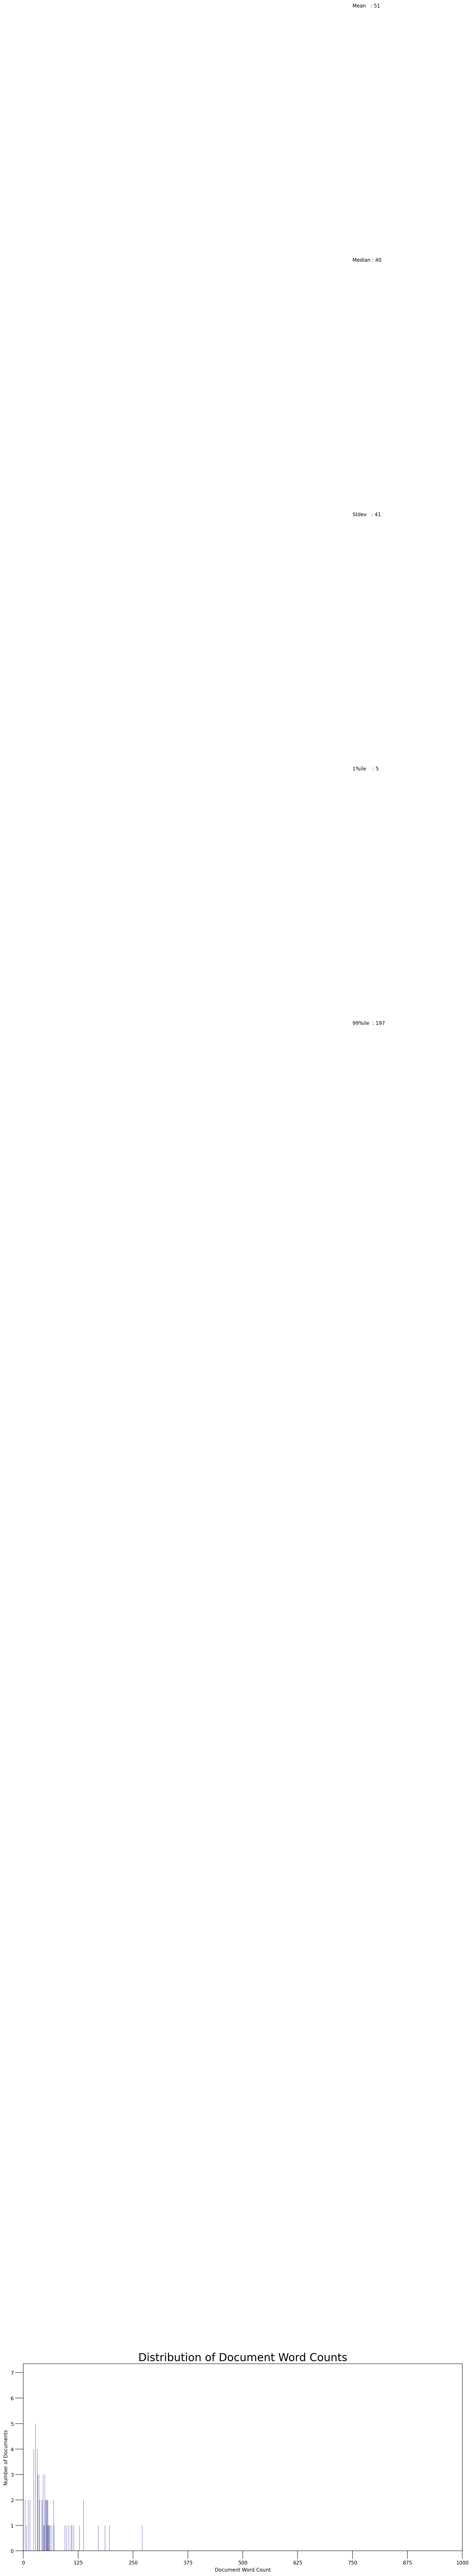

In [42]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

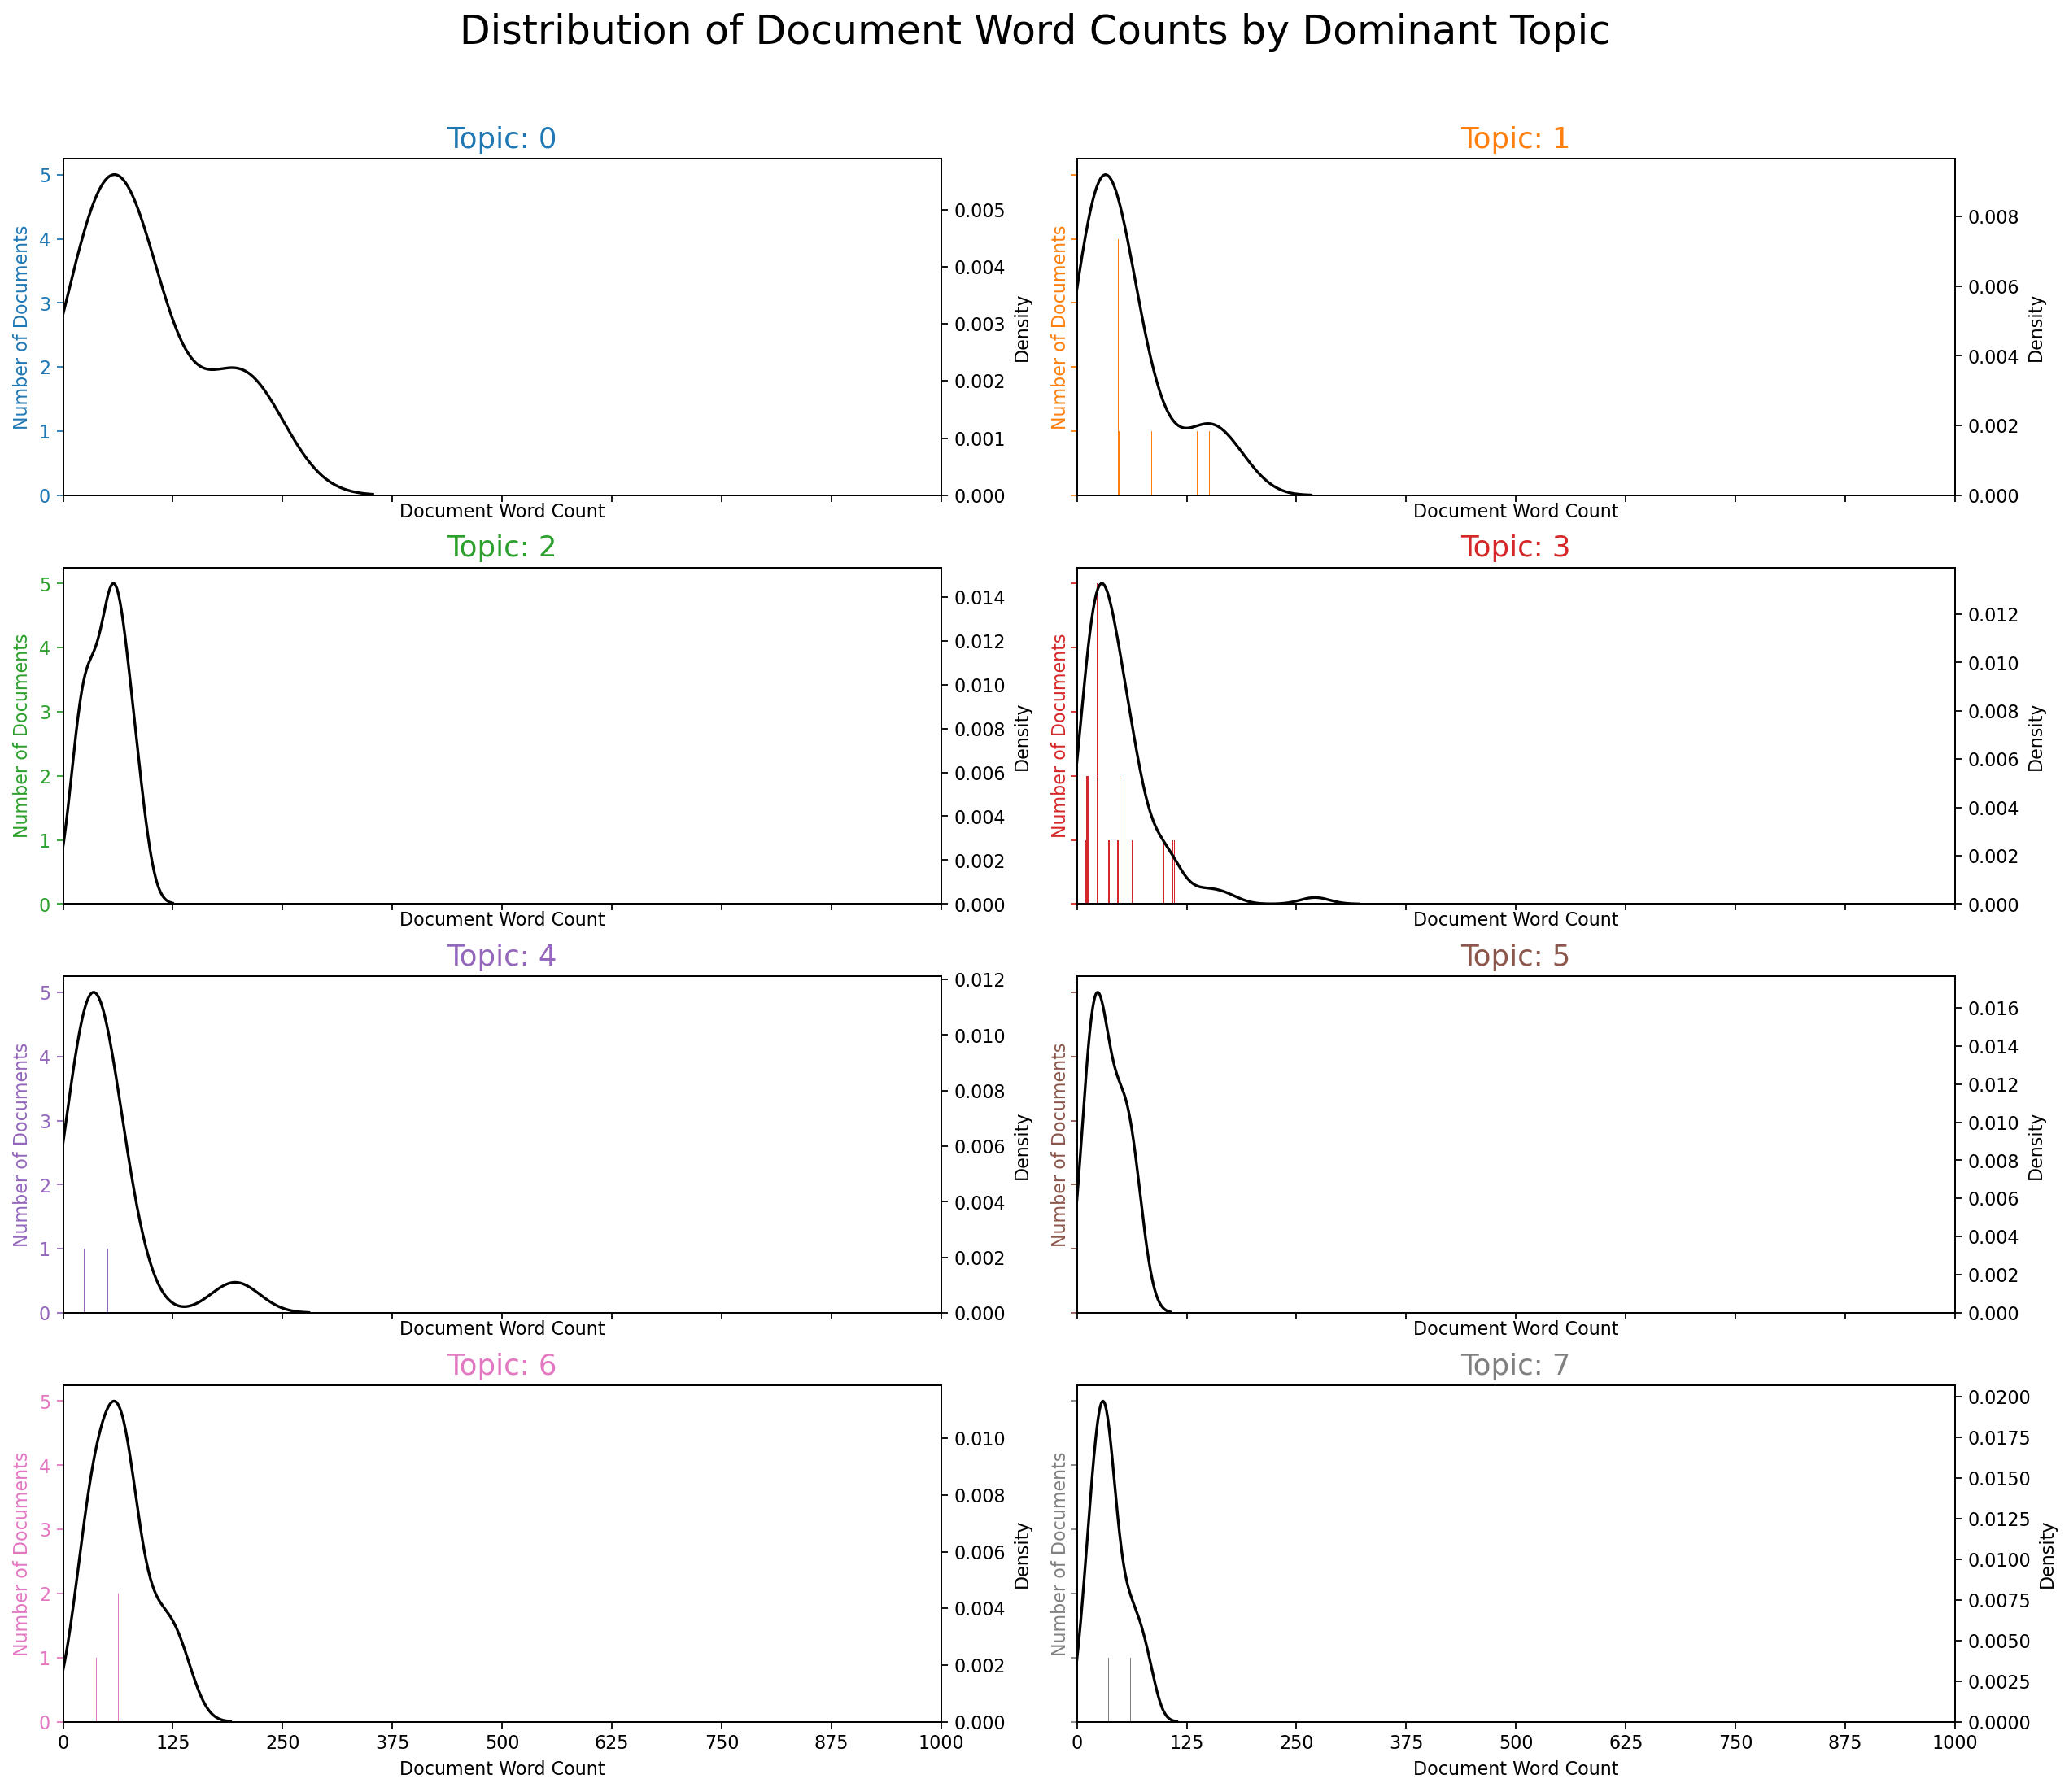

In [43]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

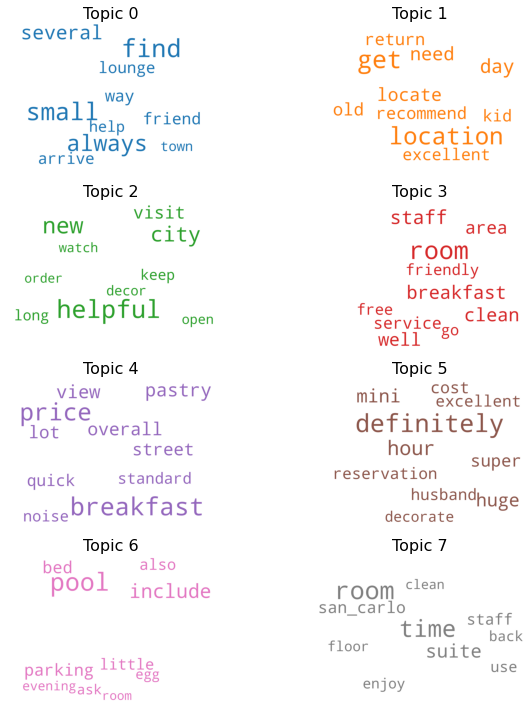

In [44]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mihir\anaconda3\envs\myenv\lib\site-packages\ipykernel_launch

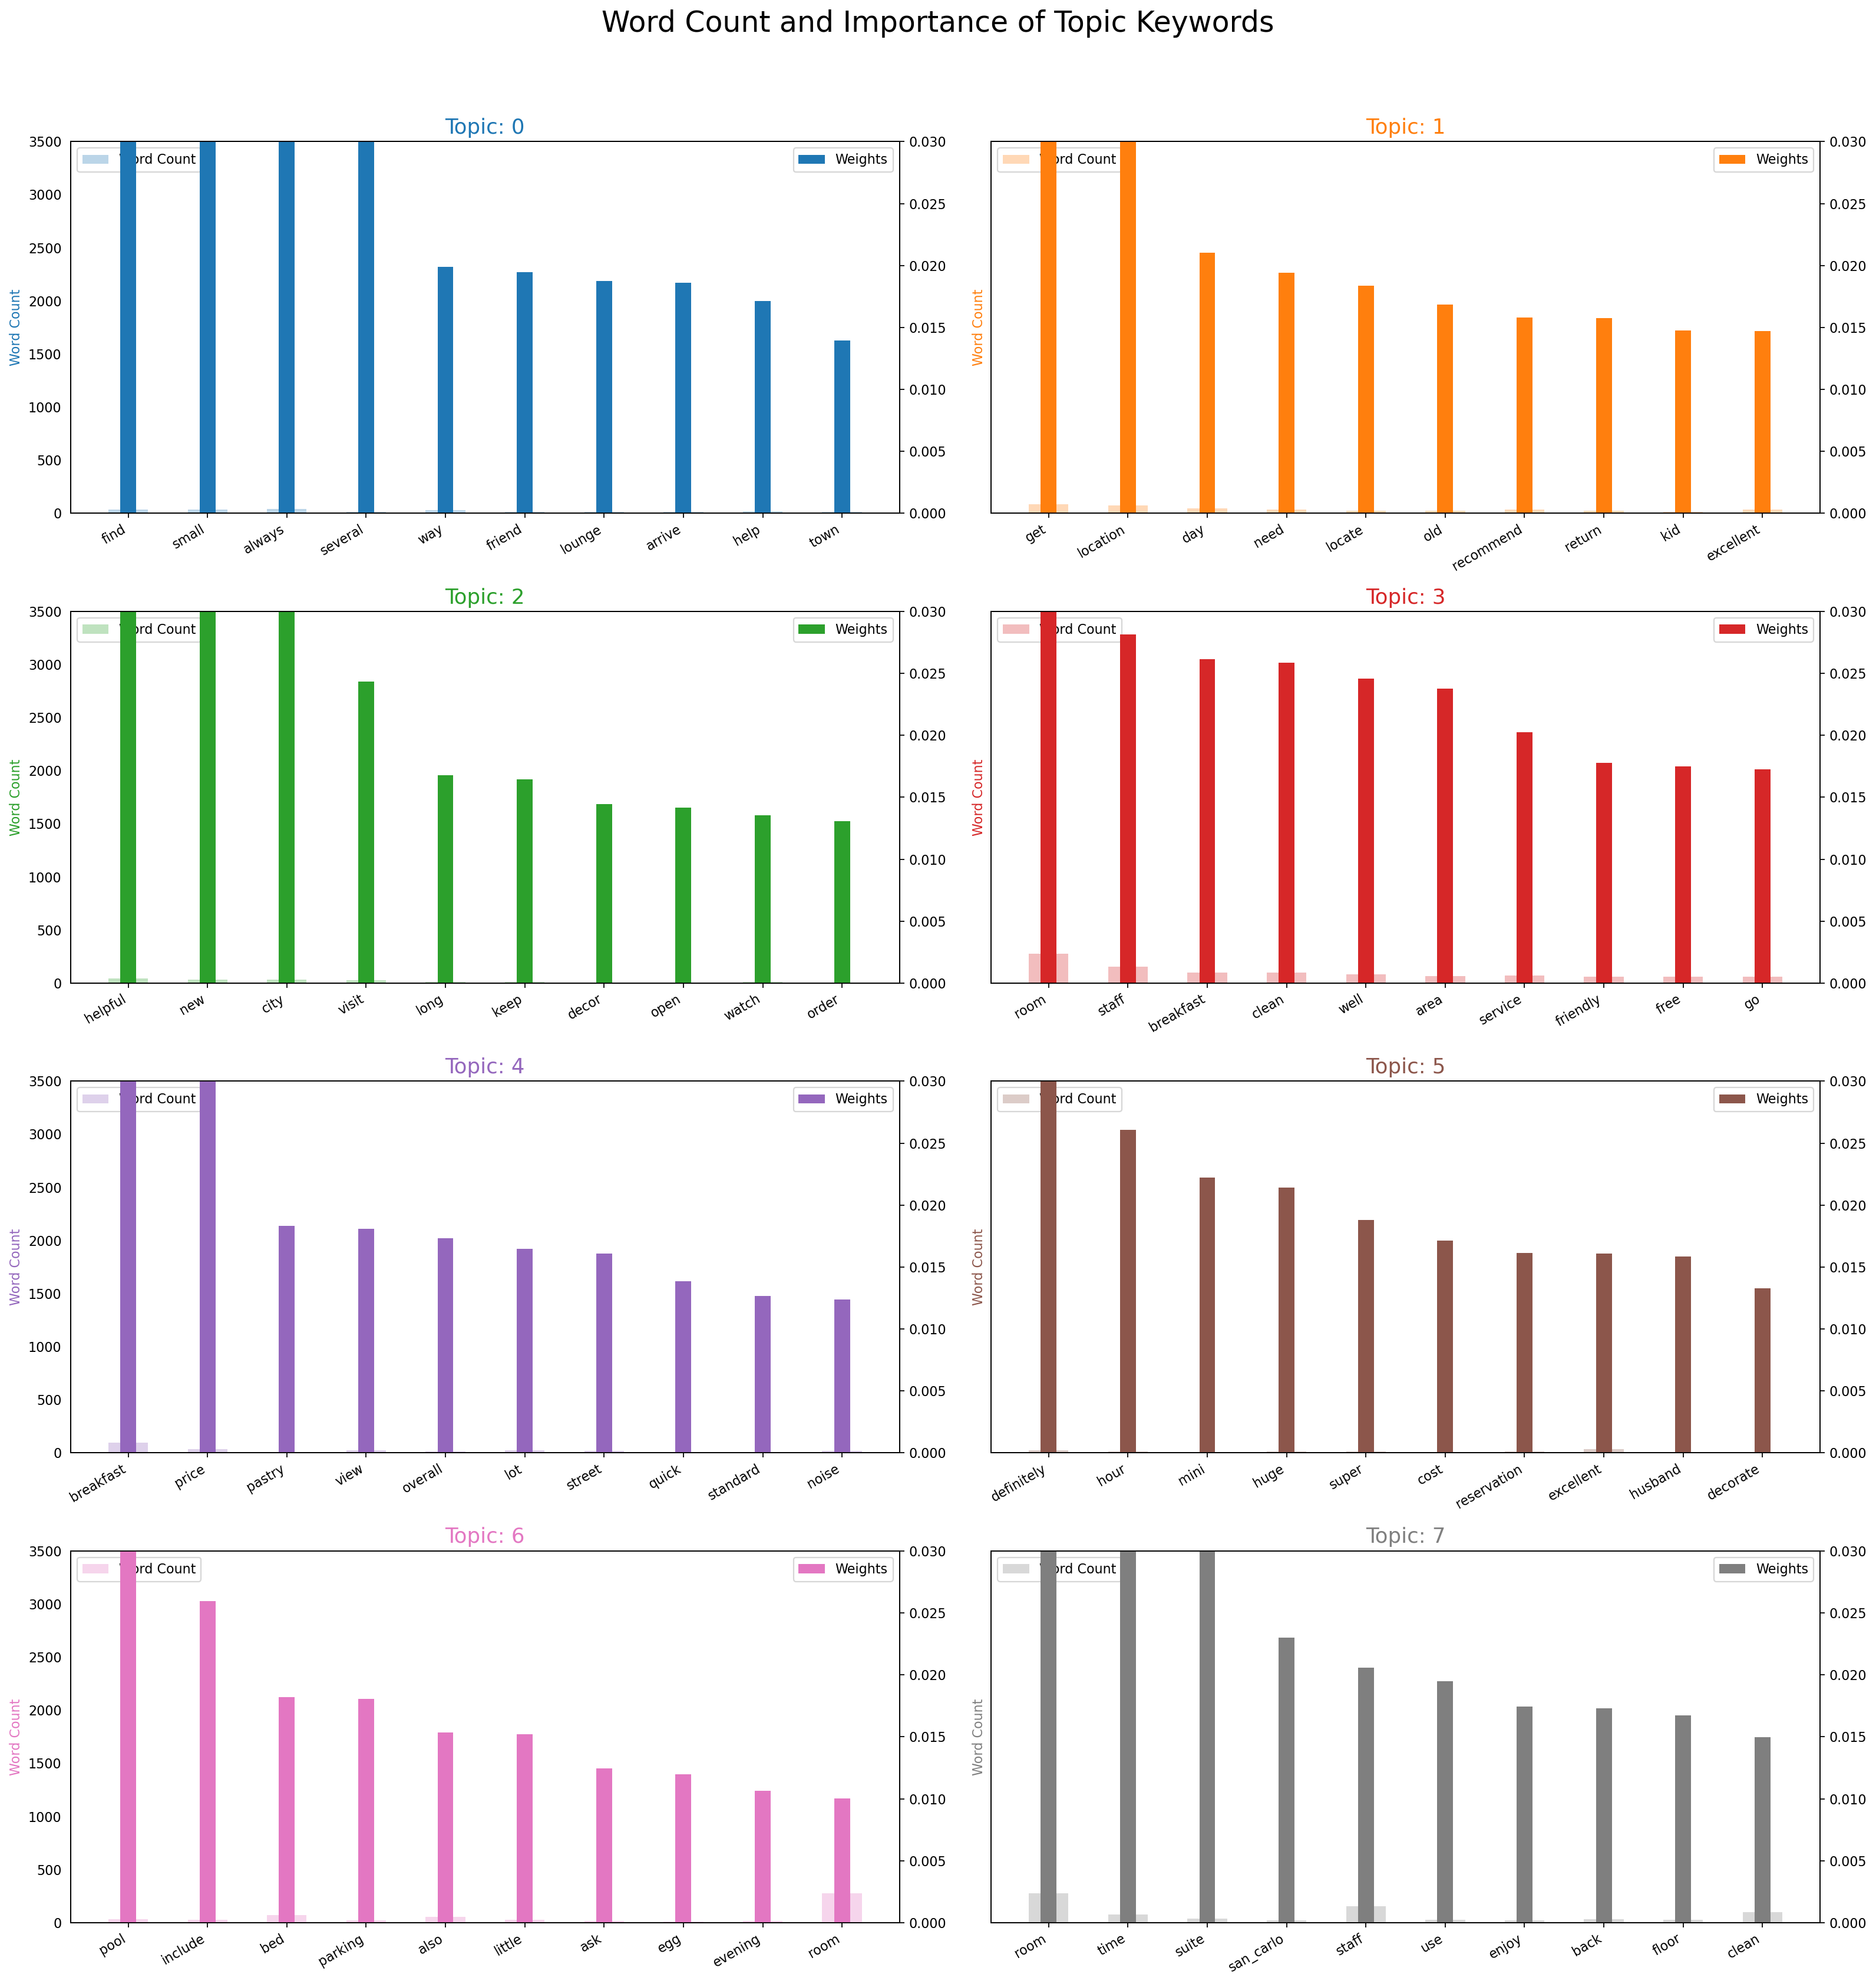

In [47]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

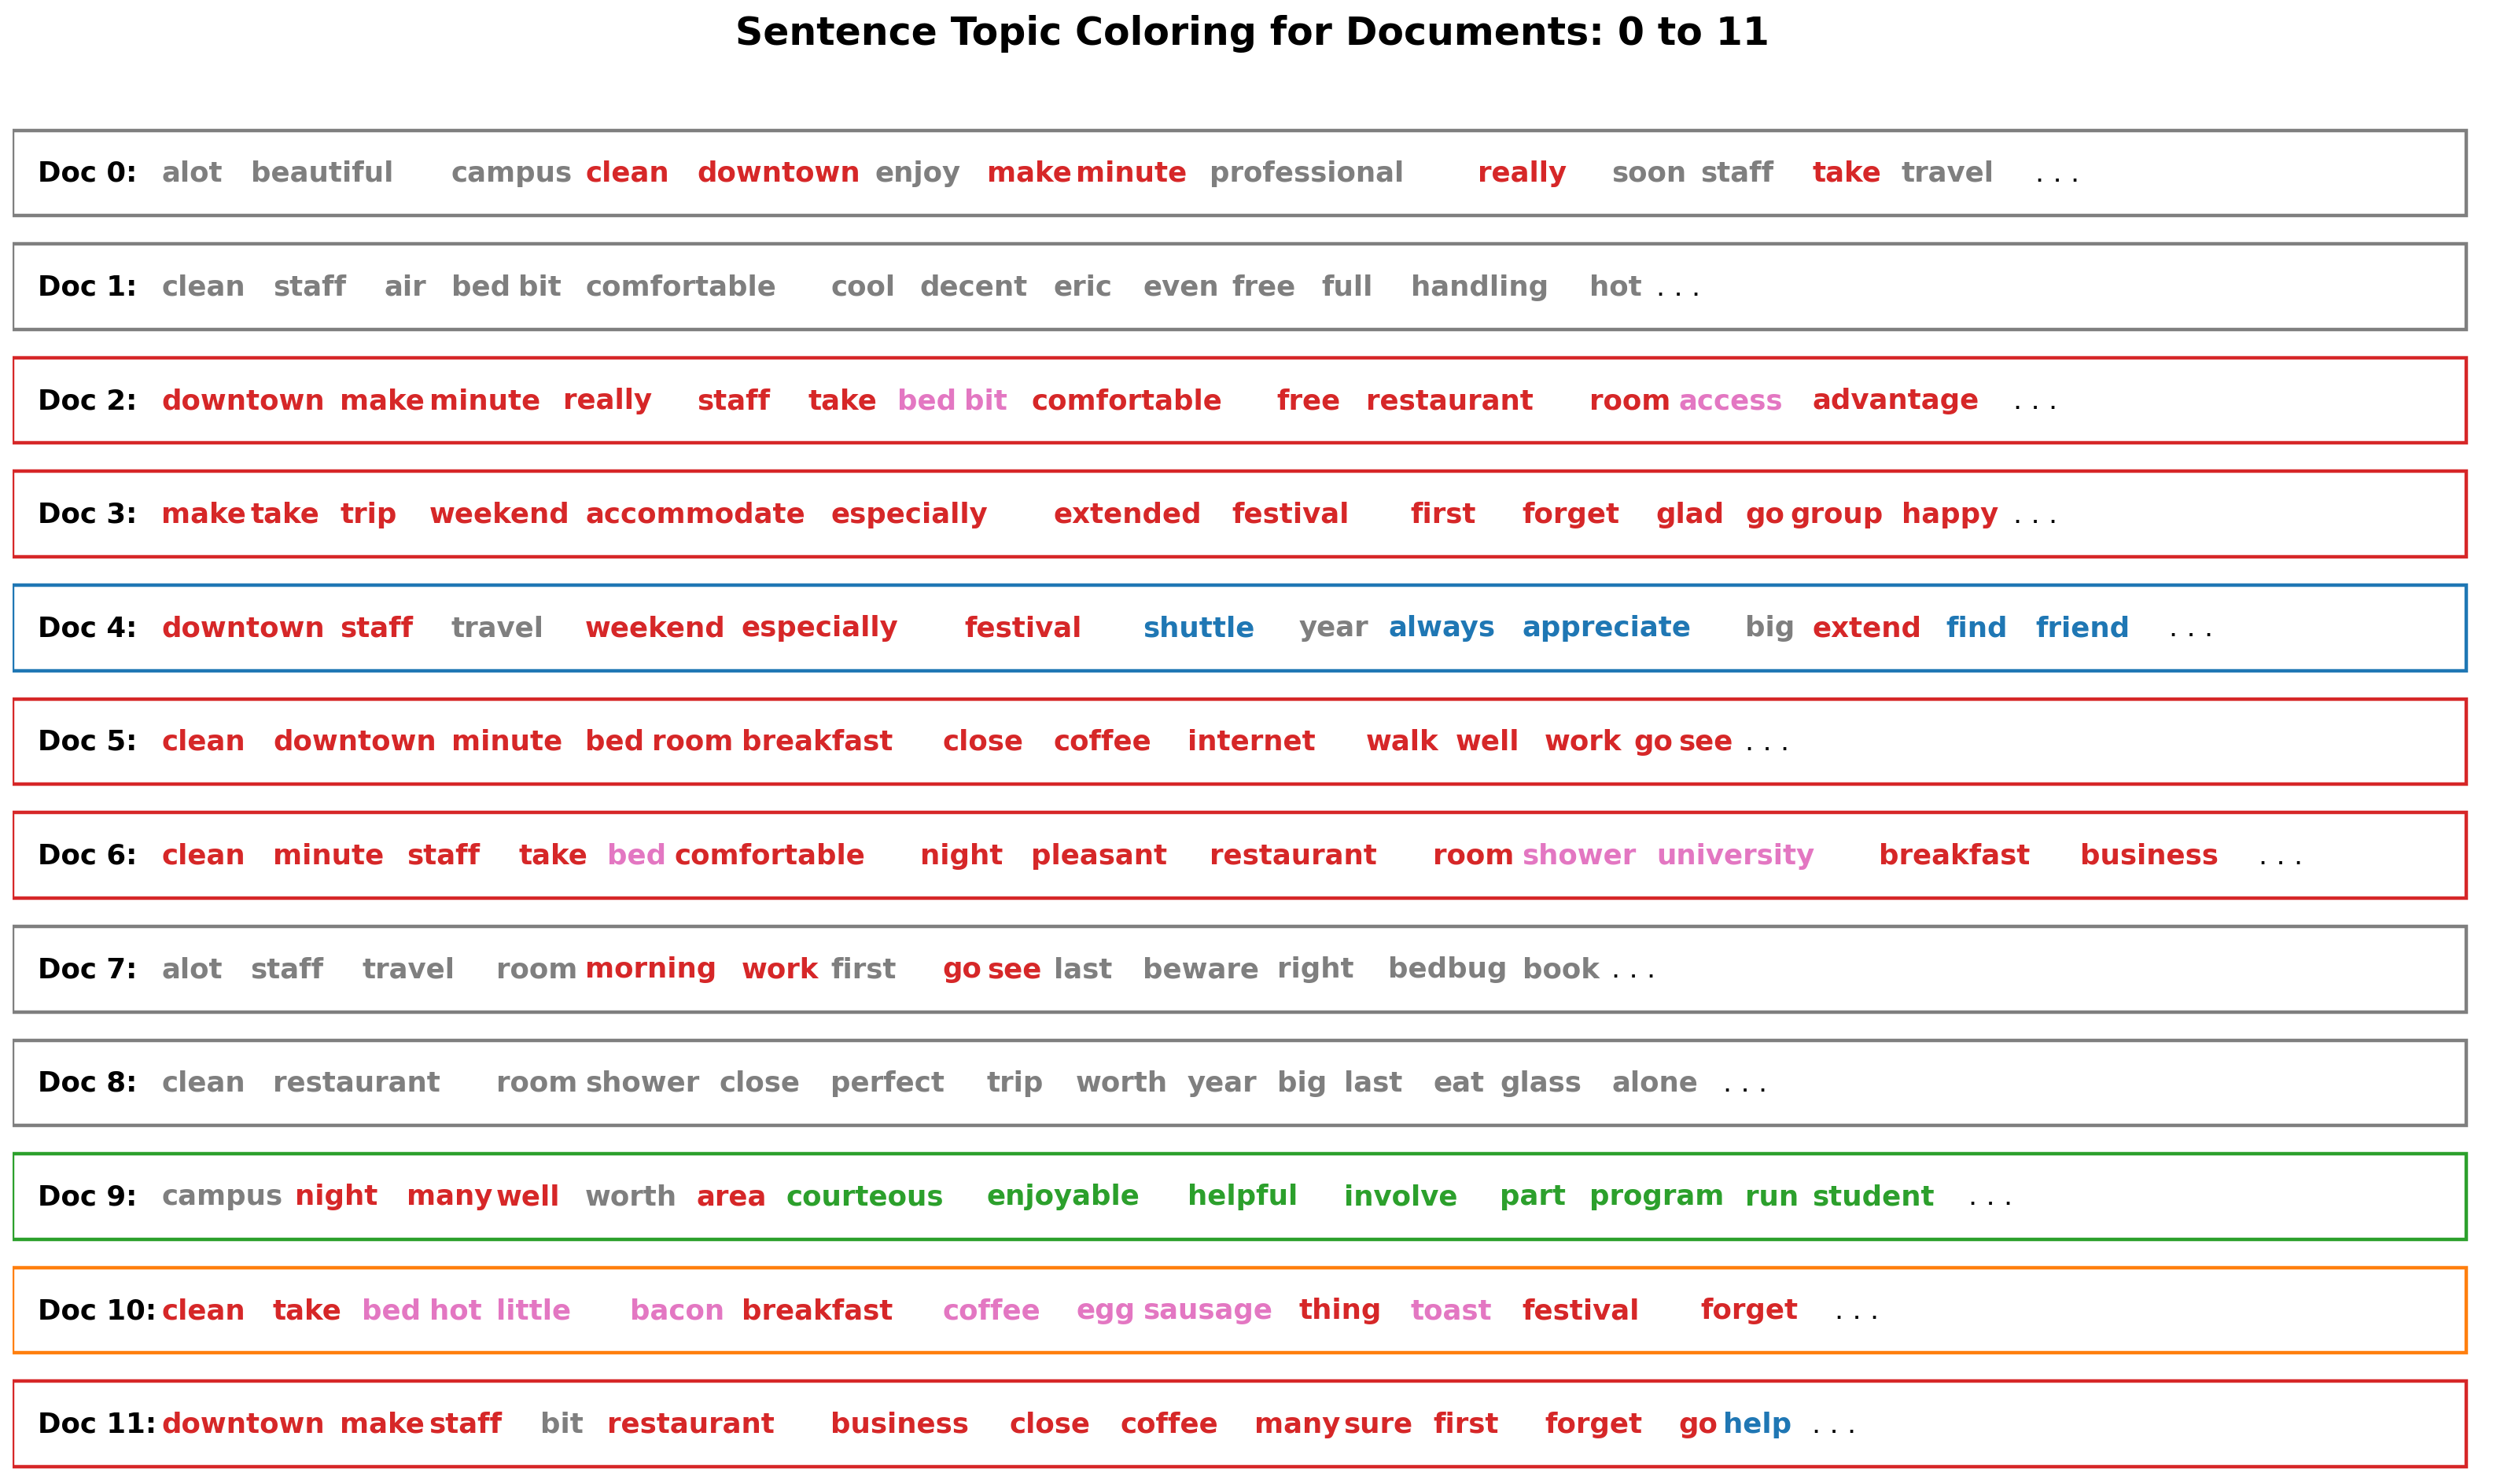

In [48]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [49]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [21]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 156 samples in 0.001s...
[t-SNE] Computed neighbors for 156 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 156 / 156
[t-SNE] Mean sigma: 0.238066
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.802288
[t-SNE] KL divergence after 1000 iterations: 0.288194


Loading BokehJS ...

In [19]:
!pip install bokeh

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for bokeh: filename=bokeh-2.3.3-py3-none-any.whl size=11342794 sha256=7091bbfb9fae42128d5de0081522a48fd8f0a8e00b97f3d9788cd76989a73b07
  Stored in directory: c:\users\mihir\appdata\local\pip\cache\wheels\8b\59\97\257265b741bab184e0cc8f5676309cb1fe6fbda22011bbb3ff
Successfully built bokeh
